In [147]:
import pandas as pd

from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from geopy.extra.rate_limiter import RateLimiter

import requests # library to handle requests

import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import pyplot as plt

from sklearn.cluster import KMeans

import folium # map rendering library
from credentials import *

%matplotlib inline

## Reading the dataset and select needed columns

In [148]:
london_population = pd.read_csv('london_population.csv')

In [52]:
print(london_population.shape)
print(london_population.columns)

(24960, 9)
Index(['Code', 'Borough', 'Ward_Name', 'Year', 'Population', 'Hectares',
       'Square_Kilometres', 'Population_per_hectare',
       'Population_per_square_kilometre'],
      dtype='object')


In [53]:
london_population = london_population[london_population.Year == 2020].reset_index(drop=True)
print(london_population.shape)
london_population.columns = ['Code', 'Borough', 'Neighborhood', 'Year', 'Population', 'Hectares',
       'Square_Kilometres', 'Population_per_hectare',
       'Population_per_square_kilometre']
london_population.head()

(624, 9)


Code                 Borough Neighborhood  Year  Population  Hectares  \
0  E05000026    Barking and Dagenham        Abbey  2020       16246     127.9   
1  E05000455                  Merton        Abbey  2020       10933     139.3   
2  E05000630             Westminster   Abbey Road  2020       13331     109.5   
3  E05000214               Greenwich   Abbey Wood  2020       16376     265.3   
4  E05000382  Kensington and Chelsea    Addington  2020       11203      62.9   

   Square_Kilometres  Population_per_hectare  Population_per_square_kilometre  
0              1.279              127.021110                     12702.111020  
1              1.393               78.485284                      7848.528356  
2              1.095              121.744292                     12174.429220  
3              2.653               61.726348                      6172.634753  
4              0.629              178.108108                     17810.810810

## For each address (Neighborhood, Borough) get the Latitude and Longitude

In [15]:
geolocator = Nominatim(user_agent="londo_explorer")
def get_lat_long(df):
    list_lat_long = []
    for index, row in df.iterrows():
        latitude, longitude = 0, 0
#         print(row['address'])       
        geocode = RateLimiter(geolocator.geocode, min_delay_seconds=4)
        location = geocode(row['address'])
        if location:
            latitude = location.latitude
            longitude = location.longitude
        list_lat_long.append([latitude, longitude])
    return list_lat_long

In [16]:
london_population['address'] = london_population['Neighborhood'] + ", " + london_population['Borough'] + ", England"

In [23]:
# lat_long
df_lat_long = pd.DataFrame.from_records(lat_long)
london_population[['Latitude', 'Longitude']] = df_lat_long

In [55]:
london_population = london_population[london_population.Latitude != 0]

## For each Netighborhood get the nearby venues

In [48]:
LIMIT = 100
VERSION = '20200415'

def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)


In [150]:
london_venues = getNearbyVenues(names=london_population['Neighborhood'],
                                   latitudes=london_population['Latitude'],
                                   longitudes=london_population['Longitude'])

## Exploring the dataset

### Number of neighborhood for each borough in London

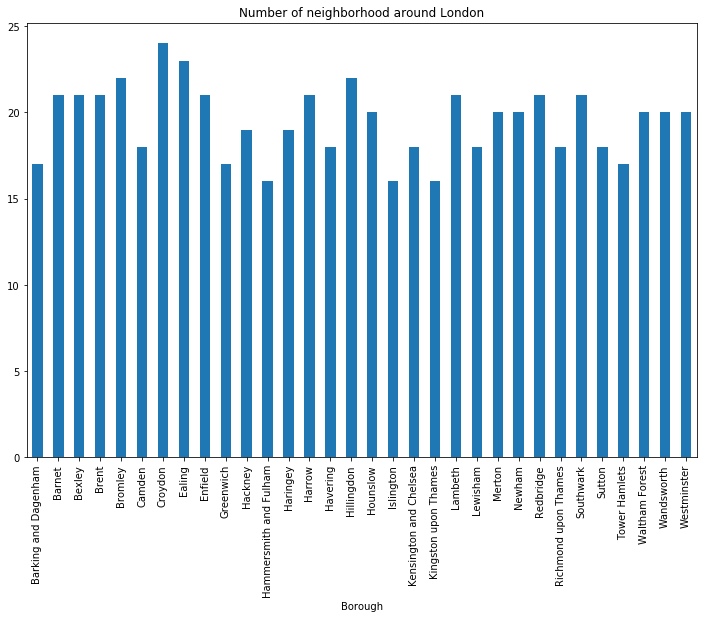

In [186]:
plt.figure(figsize=(12,8))
london_population.groupby('Borough')['Neighborhood'].count().plot(kind='bar')
plt.title('Number of neighborhood around London')

### London's most crowded boroughs

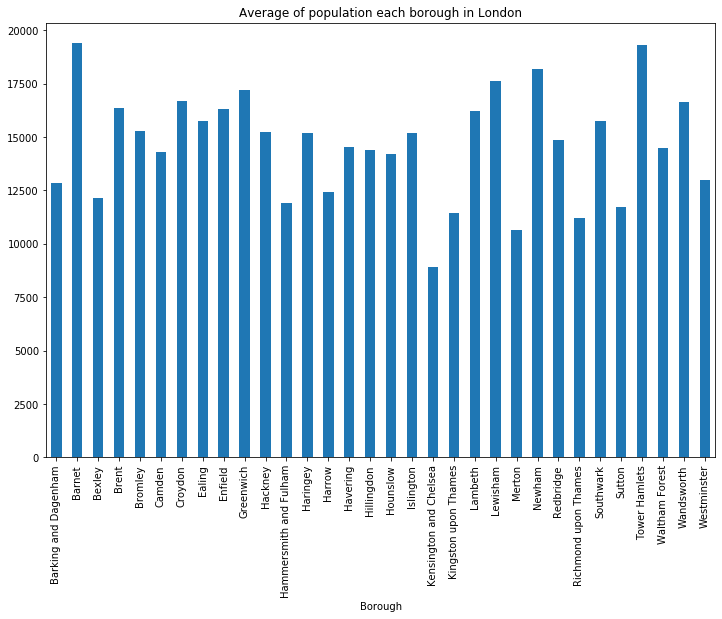

In [187]:
plt.figure(figsize=(12,8))
london_population.groupby('Borough')['Population'].mean().plot(kind='bar')
plt.title('Average of population each borough in London')

In [153]:
london_venues.groupby('Neighborhood').count()

Neighborhood Latitude  Neighborhood Longitude  Venue  \
Neighborhood                                                                    
Abbey                                       50                      50     50   
Abbey Road                                  21                      21     21   
Abbey Wood                                   4                       4      4   
Acton Central                               18                      18     18   
Addiscombe                                  11                      11     11   
Addison                                     47                      47     47   
Aldborough                                   4                       4      4   
Alexandra                                   14                      14     14   
Alibon                                       4                       4      4   
Alperton                                     8                       8      8   
Ashburton                                    8                       8      8   
Askew                                       36                      36     36   
Balham                                      54                      54     54   
Barkingside                                  4                       4      4   
Barnehurst                                   4                       4      4   
Barnes                                      21                      21     21   
Barnhill                                     7                       7      7   
Barnsbury                                   22                      22     22   
Bayswater                                  100                     100    100   
Beckton                                     13                      13     13   
Becontree                                    4                       4      4   
Beddington North                             4                       4      4   
Beddington South                             4                       4      4   
Bedfont                                      6                       6      6   
Bedford                                     56                      56     56   
Bellingham                                   6                       6      6   
Belmont                                     12                      12     12   
Belsize                                     52                      52     52   
Belvedere                                    3                       3      3   
Bensham Manor                                4                       4      4   
...                                        ...                     ...    ...   
West Ham                                    12                      12     12   
West Hampstead                              42                      42     42   
West Harrow                                  4                       4      4   
West Hendon                                 12                      12     12   
West Hill                                   11                      11     11   
West Putney                                 81                      81     81   
West Ruislip                                10                      10     10   
West Thornton                               10                      10     10   
West Twickenham                             47                      47     47   
West Wickham                                13                      13     13   
Westbourne                                  30                      30     30   
Whalebone                                    4                       4      4   
White Hart Lane                             17                      17     17   
Whitechapel                                 35                      35     35   
Whitefoot                                    4                       4      4   
Whitton                                     24                      24     24   
Wick                                        35          

In [154]:
print('There are {} uniques categories.'.format(len(london_venues['Venue Category'].unique())))

There are 412 uniques categories.


### Neighborhoods where exists Brazilian Restaurants

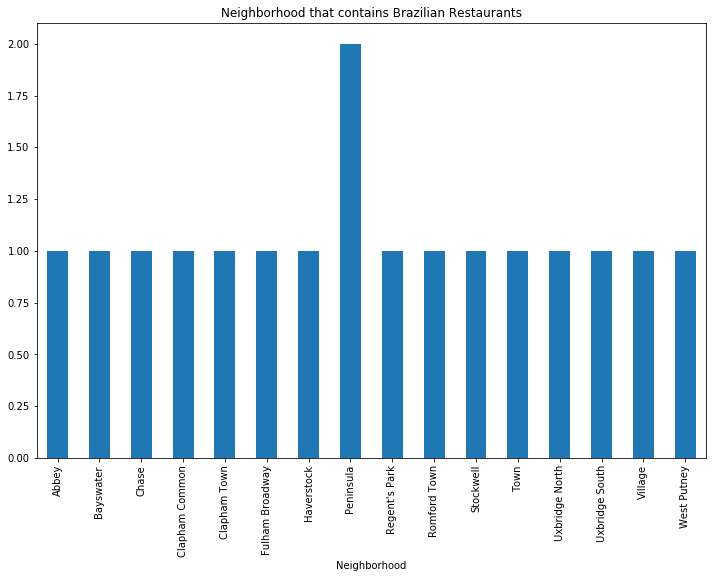

In [189]:
neighborhoods_brazilian_restaurants = london_venues[london_venues['Venue Category'].str.contains('Brazil', case=False)]
plt.figure(figsize=(12,8))
neighborhoods_brazilian_restaurants.groupby('Neighborhood')['Neighborhood'].count().plot(kind='bar')
plt.title('Neighborhood that contains Brazilian Restaurants')

### Get only neighborhoods where exists Brazilian Restaurants to cluster

In [156]:
london_venues_brazilian_restaurants = london_venues[london_venues['Neighborhood'].isin(neighborhoods_brazilian_restaurants['Neighborhood'])]

In [157]:
london_venues_brazilian_restaurants.shape

(1184, 7)

In [158]:
# london_venues_brazilian_restaurants

In [159]:
london_onehot = pd.get_dummies(london_venues_brazilian_restaurants[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
london_onehot['Neighborhood'] = london_venues_brazilian_restaurants['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [london_onehot.columns[-1]] + list(london_onehot.columns[:-1])
london_onehot = london_onehot[fixed_columns]

london_onehot.head()

Neighborhood  African Restaurant  American Restaurant  \
0        Abbey                   0                    0   
1        Abbey                   0                    0   
2        Abbey                   0                    0   
3        Abbey                   0                    0   
4        Abbey                   0                    0   

   Argentinian Restaurant  Art Gallery  Arts & Crafts Store  \
0                       0            0                    0   
1                       0            0                    0   
2                       0            0                    0   
3                       0            0                    0   
4                       0            0                    0   

   Arts & Entertainment  Asian Restaurant  Austrian Restaurant  BBQ Joint  \
0                     0                 0                    0          0   
1                     0                 0                    0          0   
2                     0                 0                    0          0   
3                     0                 0                    0          0   
4                     0                 0                    0          0   

   ...  Vegetarian / Vegan Restaurant  Video Game Store  \
0  ...                              0                 0   
1  ...                              0                 0   
2  ...                              0                 0   
3  ...                              0                 0   
4  ...                              0                 0   

   Vietnamese Restaurant  Warehouse Store  Wine Bar  Wine Shop  Wings Joint  \
0                      0                0         0          0            0   
1                      0                0         0          0            0   
2                      0                0         0          0            0   
3                      0                0         0          0            0   
4                      0                0         0          0            0   

   Women's Store  Yoga Studio  Zoo Exhibit  
0              0            0            0  
1              0            0            0  
2              0            0            0  
3              0            0            0  
4              0            0            0  

[5 rows x 178 columns]

In [160]:
london_grouped = london_onehot.groupby('Neighborhood').mean().reset_index()
london_grouped['Brazilian Restaurant']

0     0.020000
1     0.010000
2     0.017857
3     0.011494
4     0.011364
5     0.020408
6     0.012987
7     0.038462
8     0.020833
9     0.013333
10    0.043478
11    0.006849
12    0.015152
13    0.015152
14    0.008333
15    0.012346
Name: Brazilian Restaurant, dtype: float64

In [161]:
london_grouped.shape

(16, 178)

In [162]:
num_top_venues = 5

for hood in london_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = london_grouped[london_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Abbey----
                  venue  freq
0                 Hotel  0.12
1           Coffee Shop  0.08
2           Supermarket  0.08
3  Fast Food Restaurant  0.04
4        Discount Store  0.02


----Bayswater----
                venue  freq
0               Hotel  0.09
1                 Pub  0.07
2  Chinese Restaurant  0.05
3    Greek Restaurant  0.04
4         Coffee Shop  0.04


----Chase----
            venue  freq
0  Clothing Store  0.07
1     Coffee Shop  0.07
2    Optical Shop  0.05
3             Pub  0.05
4            Café  0.04


----Clapham Common----
          venue  freq
0           Pub  0.09
1          Café  0.05
2  Burger Joint  0.05
3   Coffee Shop  0.05
4    Restaurant  0.03


----Clapham Town----
          venue  freq
0           Pub  0.09
1          Café  0.05
2  Burger Joint  0.05
3           Bar  0.05
4   Coffee Shop  0.05


----Fulham Broadway----
            venue  freq
0     Coffee Shop  0.14
1             Pub  0.08
2            Café  0.08
3  Soccer Stadium  0.06


In [165]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [166]:
import numpy as np
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = london_grouped['Neighborhood']

for ind in np.arange(london_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(london_grouped.iloc[ind, :], 
                                                                          num_top_venues)

neighborhoods_venues_sorted

Neighborhood 1st Most Common Venue 2nd Most Common Venue  \
0             Abbey                 Hotel           Supermarket   
1         Bayswater                 Hotel                   Pub   
2             Chase           Coffee Shop        Clothing Store   
3    Clapham Common                   Pub           Coffee Shop   
4      Clapham Town                   Pub           Coffee Shop   
5   Fulham Broadway           Coffee Shop                  Café   
6        Haverstock                  Café                   Bar   
7         Peninsula                Lounge           Coffee Shop   
8     Regent's Park           Zoo Exhibit                  Café   
9      Romford Town           Coffee Shop        Clothing Store   
10        Stockwell         Grocery Store              Platform   
11             Town                   Pub           Coffee Shop   
12   Uxbridge North           Coffee Shop        Clothing Store   
13   Uxbridge South           Coffee Shop        Clothing Store   
14          Village                 Hotel                   Pub   
15      West Putney           Coffee Shop                   Pub   

   3rd Most Common Venue 4th Most Common Venue  5th Most Common Venue  \
0            Coffee Shop  Fast Food Restaurant        Harbor / Marina   
1     Chinese Restaurant                  Café       Greek Restaurant   
2                    Pub          Optical Shop       Department Store   
3                   Café          Burger Joint           Cocktail Bar   
4                    Bar                  Café           Burger Joint   
5                    Pub        Soccer Stadium                   Park   
6     Italian Restaurant                   Pub            Coffee Shop   
7           Burger Joint                   Bar    American Restaurant   
8                 Garden           Coffee Shop                   Park   
9                    Pub  Fast Food Restaurant                   Café   
10           Coffee Shop  Fast Food Restaurant  Portuguese Restaurant   
11                  Café        Clothing Store   Gym / Fitness Center   
12    Italian Restaurant              Pharmacy         Sandwich Place   
13    Italian Restaurant              Pharmacy         Sandwich Place   
14  Gym / Fitness Center           Coffee Shop                    Bar   
15                  Café   Japanese Restaurant         Clothing Store   

   6th Most Common Venue 7th Most Common Venue 8th Most Common Venue  \
0                    Pub   Lebanese Restaurant  Brazilian Restaurant   
1     Persian Restaurant           Coffee Shop                Garden   
2              Bookstore           Supermarket    Turkish Restaurant   
3                    Bar    Italian Restaurant            Restaurant   
4   Gym / Fitness Center    Italian Restaurant            Restaurant   
5   Gym / Fitness Center           Pizza Place             Gastropub   
6            Pizza Place                  Park            Restaurant   
7            Music Venue    Italian Restaurant            Restaurant   
8   Gym / Fitness Center           Art Gallery                 Plaza   
9          Shopping Mall        Sandwich Place           Supermarket   
10                Market         Deli / Bodega           Post Office   
11                 Hotel        Sandwich Place              Pharmacy   
12                   Pub                   Gym         Grocery Store   
13                   Pub                   Gym         Grocery Store   
14    Italian Restaurant          Burger Joint          Tram Station   
15           Pizza Place                Bakery         Grocery Store   

     9th Most Common Venue 10th Most Common Venue  
0             Liquor Store         Shopping Plaza  
1                   Hostel            Pizza Place  
2                     Café      Fish & Chips Shop  
3            Grocery Store            Yoga Studio  
4            Grocery Store               Bus Stop  
5                   Lounge             Sports Bar  
6                   Bakery         B

# Clustering neighborhoods

## 1. Choosing the right number of clusters

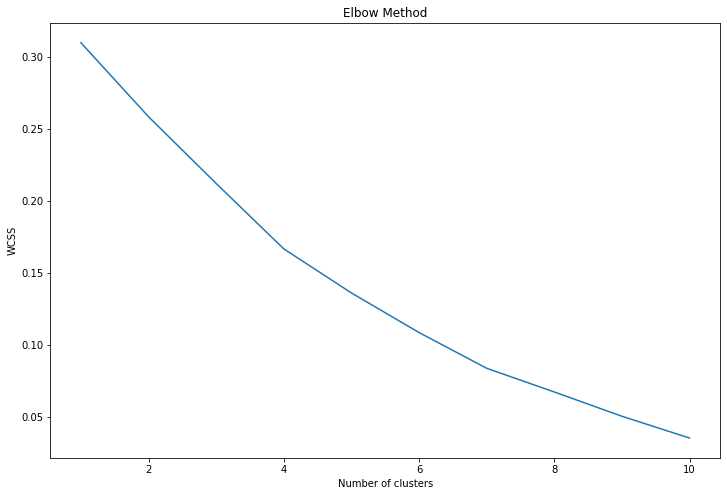

In [192]:
k_max = 10
london_grouped_clustering = london_grouped.drop('Neighborhood', 1)

wcss = []
for i in range(1, k_max+1):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(london_grouped_clustering)
    wcss.append(kmeans.inertia_)
plt.figure(figsize=(12,8))
plt.plot(range(1, k_max+1), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
# plt.show()

As we can see, the number of clusters where the change in WCSS begins to level off is 3;

## 2. K Clusters = 3

In [168]:
kmeans = KMeans(n_clusters=3, init='k-means++', max_iter=300, n_init=10, random_state=0)
kmeans.fit(london_grouped_clustering)
kmeans.labels_[0:10]

array([2, 0, 2, 0, 0, 0, 0, 0, 0, 2], dtype=int32)

In [169]:
# add clustering labels
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

london_merged = london_population[london_population.Neighborhood.isin(neighborhoods_brazilian_restaurants['Neighborhood'])]

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
london_merged = london_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

london_merged.head() # check the last columns!

Code               Borough    Neighborhood  Year  Population  \
0    E05000026  Barking and Dagenham           Abbey  2020       16246   
1    E05000455                Merton           Abbey  2020       10933   
23   E05000631           Westminster       Bayswater  2020       11660   
100  E05000195               Enfield           Chase  2020       14663   
116  E05000418               Lambeth  Clapham Common  2020       14376   

     Hectares  Square_Kilometres  Population_per_hectare  \
0       127.9              1.279              127.021110   
1       139.3              1.393               78.485284   
23       51.8              0.518              225.096525   
100    1694.4             16.944                8.653801   
116     134.3              1.343              107.043931   

     Population_per_square_kilometre                               address  \
0                       12702.111020  Abbey, Barking and Dagenham, England   
1                        7848.528356                Abbey, Merton, England   
23                      22509.652510       Bayswater, Westminster, England   
100                       865.380076               Chase, Enfield, England   
116                     10704.393150      Clapham Common, Lambeth, England   

     ...  1st Most Common Venue  2nd Most Common Venue  3rd Most Common Venue  \
0    ...                  Hotel            Supermarket            Coffee Shop   
1    ...                  Hotel            Supermarket            Coffee Shop   
23   ...                  Hotel                    Pub     Chinese Restaurant   
100  ...            Coffee Shop         Clothing Store                    Pub   
116  ...                    Pub            Coffee Shop                   Café   

    4th Most Common Venue 5th Most Common Venue 6th Most Common Venue  \
0    Fast Food Restaurant       Harbor / Marina                   Pub   
1    Fast Food Restaurant       Harbor / Marina                   Pub   
23                   Café      Greek Restaurant    Persian Restaurant   
100          Optical Shop      Department Store             Bookstore   
116          Burger Joint          Cocktail Bar                   Bar   

    7th Most Common Venue 8th Most Common Venue 9th Most Common Venue  \
0     Lebanese Restaurant  Brazilian Restaurant          Liquor Store   
1     Lebanese Restaurant  Brazilian Restaurant          Liquor Store   
23            Coffee Shop                Garden                Hostel   
100           Supermarket    Turkish Restaurant                  Café   
116    Italian Restaurant            Restaurant         Grocery Store   

    10th Most Common Venue  
0           Shopping Plaza  
1           Shopping Plaza  
23             Pizza Place  
100      Fish & Chips Shop  
116            Yoga Studio  

[5 rows x 23 columns]

In [170]:
london_merged = london_merged[london_merged['Cluster Labels'].isnull()==False]
london_merged.columns

Index(['Code', 'Borough', 'Neighborhood', 'Year', 'Population', 'Hectares',
       'Square_Kilometres', 'Population_per_hectare',
       'Population_per_square_kilometre', 'address', 'Latitude', 'Longitude',
       'Cluster Labels', '1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue'],
      dtype='object')

### For each neighborhood get the venue category most commum

In [171]:
london_frequent_venue = []#pd.DataFrame({'Borough' : [], 'Neighborhood' : [], 'Venue Category'})
cols = ['1st Most Common Venue', '2nd Most Common Venue',
       '3rd Most Common Venue', '4th Most Common Venue',
       '5th Most Common Venue', '6th Most Common Venue',
       '7th Most Common Venue', '8th Most Common Venue',
       '9th Most Common Venue', '10th Most Common Venue']

for i, row in london_merged.iterrows():
    for col in cols:
        #if london_frequent_venue.shape[0] > 0:
        london_frequent_venue.append([row['Borough'], row['Neighborhood'], row['Population'], row['Square_Kilometres'], row[col]])

In [172]:
df_london_frequent_venue = pd.DataFrame.from_records(london_frequent_venue)
df_london_frequent_venue.columns = ['Borough', 'Neighborhood', 'Population', 'Square_Kilometres', 'Venue Category']

In [173]:
df_london_frequent_venue[(df_london_frequent_venue['Venue Category'].str.contains('Restaurant')) | 
                         (df_london_frequent_venue['Venue Category'].str.contains('Food', case=False))]

Borough    Neighborhood  Population  Square_Kilometres  \
3      Barking and Dagenham           Abbey       16246              1.279   
6      Barking and Dagenham           Abbey       16246              1.279   
7      Barking and Dagenham           Abbey       16246              1.279   
13                   Merton           Abbey       10933              1.393   
16                   Merton           Abbey       10933              1.393   
17                   Merton           Abbey       10933              1.393   
22              Westminster       Bayswater       11660              0.518   
24              Westminster       Bayswater       11660              0.518   
25              Westminster       Bayswater       11660              0.518   
37                  Enfield           Chase       14663             16.944   
46                  Lambeth  Clapham Common       14376              1.343   
47                  Lambeth  Clapham Common       14376              1.343   
56                  Lambeth    Clapham Town       15507              1.120   
57                  Lambeth    Clapham Town       15507              1.120   
72                   Camden      Haverstock       14179              0.732   
77                   Camden      Haverstock       14179              0.732   
84                Greenwich       Peninsula       23434              4.482   
86                Greenwich       Peninsula       23434              4.482   
87                Greenwich       Peninsula       23434              4.482   
89                Greenwich       Peninsula       23434              4.482   
113                Havering    Romford Town       18554              2.866   
119                Havering    Romford Town       18554              2.866   
123                 Lambeth       Stockwell       16075              0.869   
124                 Lambeth       Stockwell       16075              0.869   
138                 Enfield            Town       15988              2.233   
139                 Enfield            Town       15988              2.233   
148  Hammersmith and Fulham            Town       11058              0.650   
149  Hammersmith and Fulham            Town       11058              0.650   
152              Hillingdon  Uxbridge North       16260              4.633   
162              Hillingdon  Uxbridge South       15930              3.117   
175    Barking and Dagenham         Village       11212              2.140   
185                  Merton         Village        8594              6.218   
195               Southwark         Village       13029              2.788   
203              Wandsworth     West Putney       15454              1.846   
209              Wandsworth     West Putney       15454              1.846   

            Venue Category  
3     Fast Food Restaurant  
6      Lebanese Restaurant  
7     Brazilian Restaurant  
13    Fast Food Restaurant  
16     Lebanese Restaurant  
17    Brazilian Restaurant  
22      Chinese Restaurant  
24        Greek Restaurant  
25      Persian Restaurant  
37      Turkish Restaurant  
46      Italian Restaurant  
47              Restaurant  
56      Italian Restaurant  
57              Restaurant  
72      Italian Restaurant  
77              Restaurant  
84     American Restaurant  
86      Italian Restaurant  
87              Restaurant  
89    Brazilian Restaurant  
113   Fast Food Restaurant  
119     Italian Restaurant  
123   Fast Food Restaurant  
124  Portuguese Restaurant  
138   Fast Food Restaurant  
139     Turkish Restaurant  
148   Fast Food Restaurant  
149     Turkish Restaurant  
152     Italian Restaurant  
162     Italian Restaurant  
175     Italian Restaurant  
185     Italian Restaurant  
195     Italian Restaurant  
203    Japanese Restaurant  
209     Italian Restaurant

### Number of restaurants per neighborhood

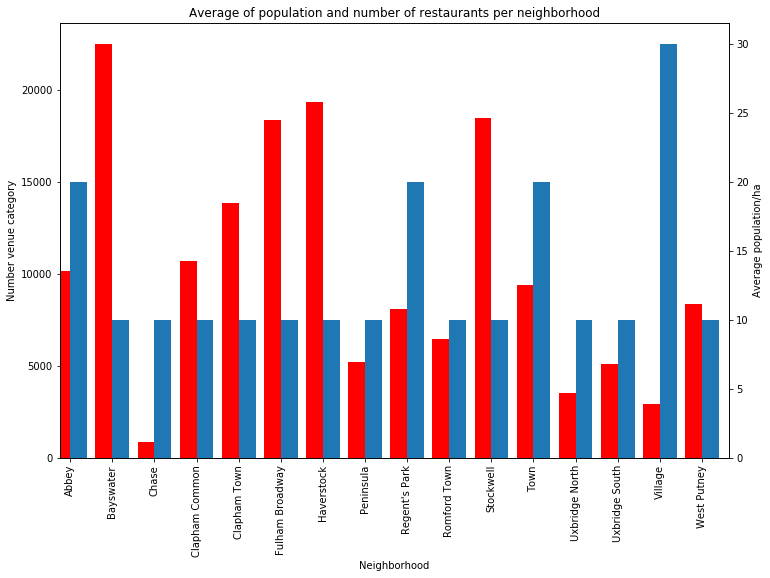

In [193]:
fig = plt.figure(figsize = (12,8)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx() 
width = 0.4          
(df_london_frequent_venue.groupby('Neighborhood')['Population'].mean()/
df_london_frequent_venue.groupby('Neighborhood')['Square_Kilometres'].mean()).plot(kind='bar', color= 'red', ax=ax, width=width, position=1)
df_london_frequent_venue.groupby('Neighborhood')['Venue Category'].count().plot(kind='bar', ax=ax2, width=width, position=0)
ax.set_ylabel('Number venue category')
ax2.set_ylabel('Average population/ha')
plt.title('Average of population and number of restaurants per neighborhood')

In [175]:
df_final = df_london_frequent_venue.groupby('Neighborhood')['Population'].mean()/df_london_frequent_venue.groupby('Neighborhood')['Square_Kilometres'].mean()
df_london_frequent_venue.groupby('Neighborhood')['Venue Category'].count()

Neighborhood
Abbey              20
Bayswater          10
Chase              10
Clapham Common     10
Clapham Town       10
Fulham Broadway    10
Haverstock         10
Peninsula          10
Regent's Park      20
Romford Town       10
Stockwell          10
Town               20
Uxbridge North     10
Uxbridge South     10
Village            30
West Putney        10
Name: Venue Category, dtype: int64

In [176]:
final = (df_london_frequent_venue.groupby('Neighborhood')['Population'].mean()/df_london_frequent_venue.groupby('Neighborhood')\
 ['Square_Kilometres'].mean()).to_frame().reset_index()
final.columns = ['Neighborhood', 'Population_per_hectares']
final = final.merge(df_london_frequent_venue.groupby('Neighborhood', as_index=False)['Venue Category'].count(), on='Neighborhood')
final = final.merge(london_merged[['Borough','Neighborhood','Cluster Labels', 'Latitude', 'Longitude']], how='left', on='Neighborhood')
# df_london_frequent_venue.groupby('Neighborhood')['Venue Category'].count()

In [177]:
final.head()

Neighborhood  Population_per_hectares  Venue Category  \
0           Abbey             10171.781437              20   
1           Abbey             10171.781437              20   
2       Bayswater             22509.652510              10   
3           Chase               865.380076              10   
4  Clapham Common             10704.393150              10   

                Borough  Cluster Labels   Latitude  Longitude  
0  Barking and Dagenham               2  51.535688   0.075530  
1                Merton               2  51.413054  -0.183346  
2           Westminster               0  51.512276  -0.188385  
3               Enfield               2  51.652085  -0.081017  
4               Lambeth               0  51.462075  -0.137359

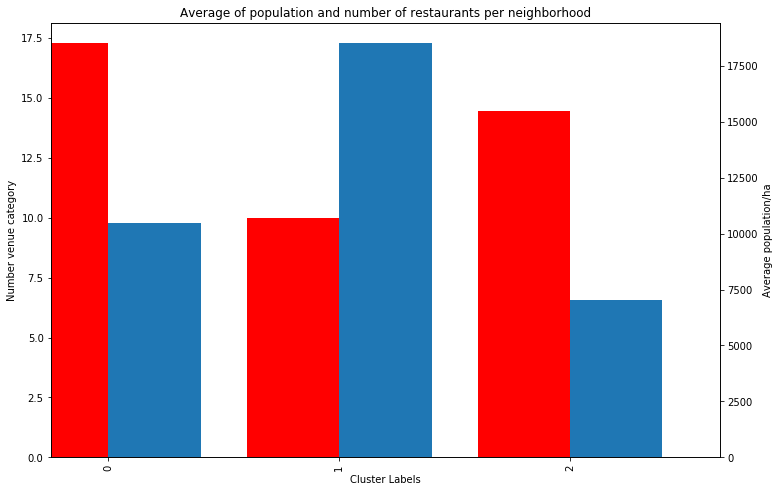

In [195]:
fig = plt.figure(figsize = (12,8)) 
ax = fig.add_subplot(111)
ax2 = ax.twinx() 
width = 0.4          
final.groupby('Cluster Labels')['Venue Category'].mean().plot(kind='bar', color= 'red', ax=ax, width=width, position=1)
final.groupby('Cluster Labels')['Population_per_hectares'].mean().plot(kind='bar', ax=ax2, width=width, position=0)
ax.set_ylabel('Number venue category')
ax2.set_ylabel('Average population/ha')
plt.title('Average of population and number of restaurants per neighborhood')
#final.groupby('Cluster Labels')['Venue Category'].mean().plot(kind='bar')

In [194]:
final[final['Cluster Labels'] != 1].groupby('Neighborhood', as_index=False)[['Population_per_hectares', 
                                                                            'Venue Category', 'Latitude', 'Longitude', 'Cluster Labels']].mean()

Neighborhood  Population_per_hectares  Venue Category   Latitude  \
0             Abbey             10171.781437              20  51.474371   
1         Bayswater             22509.652510              10  51.512276   
2             Chase               865.380076              10  51.652085   
3    Clapham Common             10704.393150              10  51.462075   
4      Clapham Town             13845.535714              10  51.462292   
5   Fulham Broadway             18371.814093              10  51.480883   
6        Haverstock             19370.218579              10  51.544868   
7         Peninsula              5228.469433              10  51.502931   
8     Regent's Park              8097.615086              20  51.526930   
9      Romford Town              6473.831124              10  51.576046   
10             Town              9381.200139              20  51.572105   
11   Uxbridge North              3509.605008              10  51.546655   
12   Uxbridge South              5110.683349              10  51.546655   
13          Village              2945.899874              30  51.489281   
14      West Putney              8371.614301              10  51.460934   

    Longitude  Cluster Labels  
0   -0.053908               2  
1   -0.188385               0  
2   -0.081017               2  
3   -0.137359               0  
4   -0.138856               0  
5   -0.194349               0  
6   -0.153213               0  
7    0.003197               0  
8   -0.150284               0  
9    0.182265               2  
10  -0.152579               2  
11  -0.477511               2  
12  -0.477511               2  
13  -0.047017               0  
14  -0.215348               2

In [183]:
geolocator = Nominatim(user_agent="londo_explorer")
location = geolocator.geocode('London, England')
latitude = location.latitude
longitude = location.longitude
f'{latitude}, {longitude}'

'51.5073219, -0.1276474'

In [201]:
# create map of Toronto using latitude and longitude values
map_london = folium.Map(location=[latitude, longitude], zoom_start=10)

x = np.arange(3)
ys = [i+x+(i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]
print(rainbow)
# add markers to map
for lat, lng, borough, neighborhood, cluster in zip(final['Latitude'], final['Longitude'], 
                                           final['Borough'], final['Neighborhood'], 
                                                   final['Cluster Labels']):
    label = '{}, {}'.format(neighborhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

['#8000ff', '#80ffb4', '#ff0000']
